In [2]:
import numpy as np
import h5py
from nbodykit.lab import *
import nbodykit 
import matplotlib.pyplot as plt

In [13]:
def power_spectrum(filename):
    print(filename)
    f = h5py.File(filename, 'r')
    div_test = f['divergence'][...]
    f.close()

    div_mesh = nbodykit.source.mesh.array.ArrayMesh(div_test, 720.0) 
    r = FFTPower(div_mesh, mode='1d', dk=0.002, kmin=0.005)
    Pk = r.power

    return {'k': Pk['k'], 'Pk':(Pk['power'].real- Pk.attrs['shotnoise'])}

In [14]:
path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/"

In [15]:
pk = {}

In [16]:
filename = "velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_sigma_1.0_nside_360.hdf5"
pk['200_1.0'] = power_spectrum(path+filename)

/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_sigma_1.0_nside_360.hdf5


In [17]:
filename = "velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_sigma_2.0_nside_360.hdf5"
pk['200_2.0'] = power_spectrum(path+filename)

/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_sigma_2.0_nside_360.hdf5


In [18]:
filename = "velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_sigma_3.0_nside_360.hdf5"
pk['200_3.0'] = power_spectrum(path+filename)

/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_sigma_3.0_nside_360.hdf5


(10, 100000)

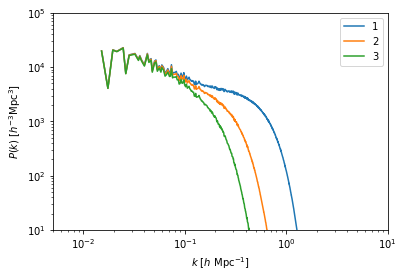

In [22]:
plt.loglog(pk['200_1.0']['k'], pk['200_1.0']['Pk'], label='1')
plt.loglog(pk['200_2.0']['k'], pk['200_2.0']['Pk'], label='2')
plt.loglog(pk['200_3.0']['k'], pk['200_3.0']['Pk'], label='3')

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend()
plt.xlim(0.005, 10.0)
plt.ylim(10,100000)

In [40]:
1/720.

0.001388888888888889